In [1]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_feature_matrices, load_metadata
from scripts.features import save_ctms, save_sequences
from utils.frobenius import create_frobenius_adjacency_matrix
from models.graph import create_movie_nodes, MovieGraph

In [2]:
save_sequences("../data/midis", "../data/sequences")
save_ctms("../data/midis", "../data/ctms")

Processing MIDIs: 17it [00:10,  1.80it/s]/home/jyanespu/project-02807/.venv/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing MIDIs: 88it [00:28,  3.13it/s]
2025-11-07 15:43:18.442 | SUCCESS  | scripts.features:save_sequences:127 - Processed 88 MIDI files -> saved to ../data/sequences/sequences_summary.csv
Processing MIDIs: 88it [00:17,  5.16it/s]
2025-11-07 15:43:35.496 | SUCCESS  | scripts.features:save_ctms:91 - Processed 88 MIDI files -> saved to ../data/ctms/summary.csv


In [3]:
matrices_df = load_feature_matrices("../data/ctms")
metadata_df = load_metadata("../data/metadata/movies_metadata.csv")
# align matrices and metadata
metadata_df = metadata_df.loc[matrices_df.index]

Loading matrices: 88it [00:00, 1020.66it/s]
2025-11-07 15:43:35.718 | SUCCESS  | utils.load:load_feature_matrices:60 - Loaded 88 matrices from ../data/ctms


In [4]:
ctms_list = matrices_df['matrix'].tolist()
frob_matrix = create_frobenius_adjacency_matrix(ctms_list)

Calculating Frobenius graph: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


In [5]:
print(metadata_df.head())
nodes = create_movie_nodes(metadata_df)
graph = MovieGraph(nodes, frob_matrix)

                                     title     released  \
id                                                        
tt0026138            Bride of Frankenstein  06 May 1935   
tt0029583  Snow White and the Seven Dwarfs  04 Feb 1938   
tt0032138                 The Wizard of Oz  25 Aug 1939   
tt0045152              Singin' in the Rain  10 Apr 1952   
tt0050212     The Bridge on the River Kwai  14 Dec 1957   

                                                director  imdbrating  \
id                                                                     
tt0026138                                    James Whale         7.8   
tt0029583  William Cottrell, David Hand, Wilfred Jackson         7.6   
tt0032138    Victor Fleming, George Cukor, Norman Taurog         8.1   
tt0045152                      Stanley Donen, Gene Kelly         8.3   
tt0050212                                     David Lean         8.1   

                                  genre  
id                                     

In [6]:
import numpy as np

def top_similar_movies_list(adjacency_matrix, nodes, top_k=10):
    """
    Returns a list of the top_k most similar movie pairs (shortest Frobenius distance).
    
    Args:
        adjacency_matrix (np.ndarray): Frobenius distance matrix.
        nodes (list): List of MovieNode objects.
        top_k (int): Number of top pairs to return.
    
    Returns:
        list of tuples: [(movie1_title, movie2_title, distance), ...]
    """
    n = adjacency_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)  # upper triangle indices
    all_pairs = [(i, j, adjacency_matrix[i, j]) for i, j in zip(*triu_idx)]
    all_pairs.sort(key=lambda x: x[2])  # smallest distance = most similar
    top_pairs = all_pairs[:top_k]
    
    return [(nodes[i].title, nodes[j].title, dist) for i, j, dist in top_pairs]

# Usage example:
top_10 = top_similar_movies_list(frob_matrix, graph.nodes, top_k=10)
for m1, m2, dist in top_10:
    print(f"{m1} <-> {m2}: distance={dist:.2f}")


E.T. the Extra-Terrestrial <-> Inception: distance=7.68
E.T. the Extra-Terrestrial <-> Transformers: distance=12.45
Transformers <-> Inception: distance=12.81
E.T. the Extra-Terrestrial <-> Gladiator: distance=13.67
Gladiator <-> Inception: distance=14.00
Gladiator <-> Transformers: distance=17.03
E.T. the Extra-Terrestrial <-> Avatar: distance=18.52
Avatar <-> Inception: distance=18.81
Transformers <-> Avatar: distance=21.17
Gladiator <-> Avatar: distance=21.91


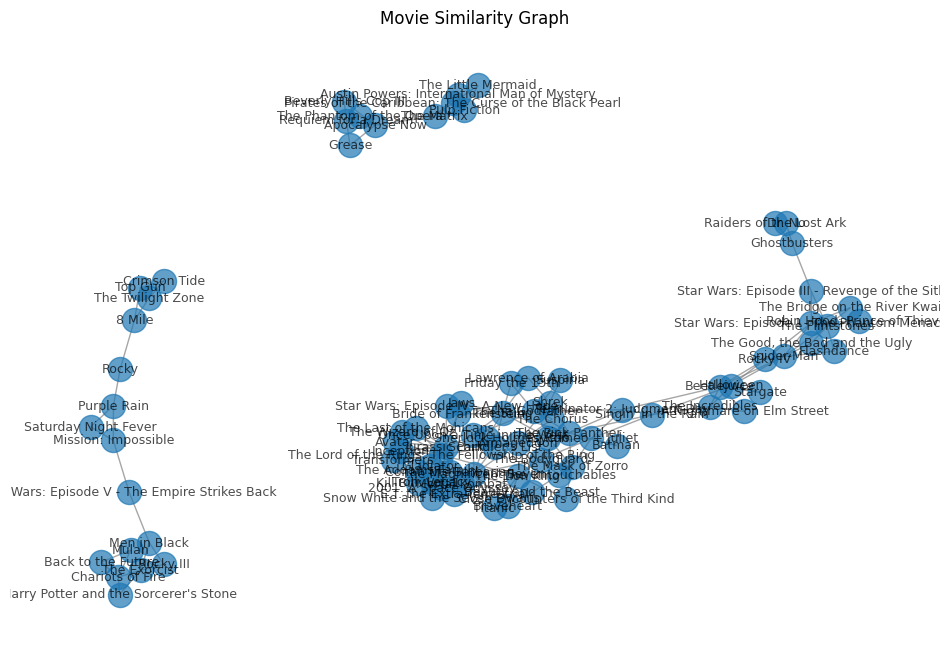

In [ ]:
threshold = np.percentile(frob_matrix[np.triu_indices_from(frob_matrix, 1)], 75)
graph.plot_graph_networkx(frob_matrix, k=2, threshold=threshold, layout="spring")

**Recall:** For small $k$ (e.g. 2, 3), only the very closest neighbors are connected. Can create many disconnected components.